# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [3]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [4]:
df1 = sim.draws_pd()
df1.head()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,218.747,8.12614,204.551
1,0.0,0.0,179.576,70.33170,288.701
2,0.0,0.0,163.480,11.77890,171.206
3,0.0,0.0,174.142,19.51800,209.511
4,0.0,0.0,146.954,4.67849,154.322


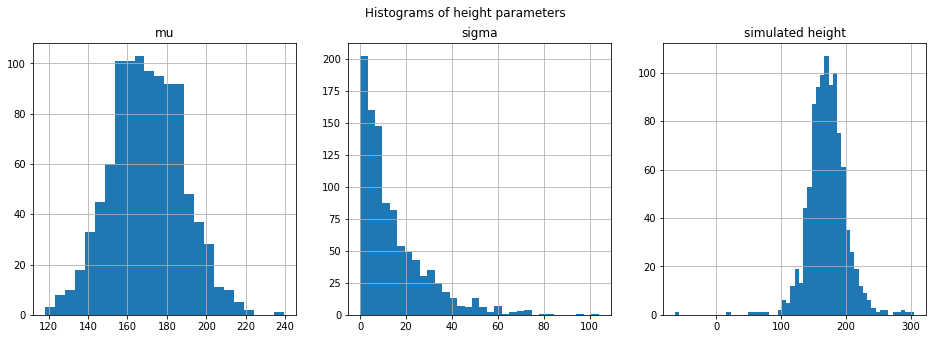

In [5]:
plt.figure(figsize=(16,5))
plt.suptitle('Histograms of height parameters')
plt.subplot(131)
plt.title('mu')
df1['mu'].hist(bins='auto')
plt.subplot(132)
plt.title('sigma')
df1['sigma'].hist(bins='auto')
plt.subplot(133)
plt.title('simulated height')
df1['height'].hist(bins='auto')
plt.show()

<AxesSubplot:title={'center':'Joint distribution of mu and sigma'}, xlabel='mu', ylabel='sigma'>

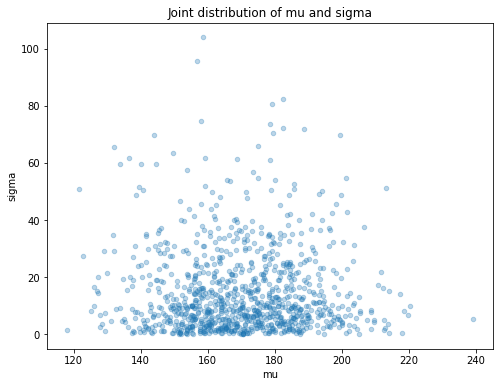

In [6]:
df1.plot(x='mu', y='sigma', kind='scatter', alpha=0.3, figsize=(8,6), title='Joint distribution of mu and sigma')

## Task 2. Model fit and evaluation

In [7]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
fit=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status






chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [9]:
df2 = fit.draws_pd()
df2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height
0,-890.263,0.975921,0.718889,2.0,3.0,0.0,890.359,154.246,7.90509,144.941
1,-891.037,0.774849,0.718889,2.0,3.0,0.0,892.234,154.462,7.30019,160.260
2,-893.031,0.501534,0.718889,2.0,7.0,0.0,895.350,155.486,8.22905,154.731
3,-892.291,0.994753,0.718889,2.0,3.0,0.0,895.029,153.746,8.05020,153.977
4,-892.409,0.988555,0.718889,2.0,3.0,0.0,894.022,155.460,8.10104,149.588


<AxesSubplot:title={'center':'Joint distribution of mu and sigma'}, xlabel='mu', ylabel='sigma'>

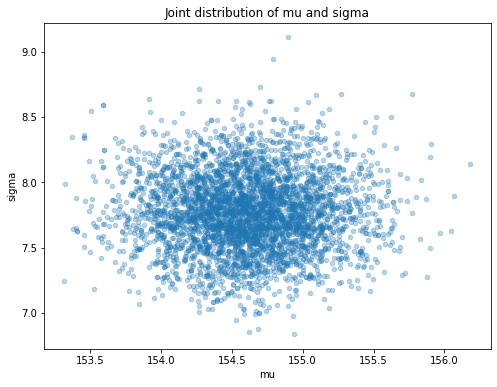

In [10]:
df2.plot(x='mu', y='sigma', kind='scatter', alpha=0.3, figsize=(8,6), title='Joint distribution of mu and sigma')

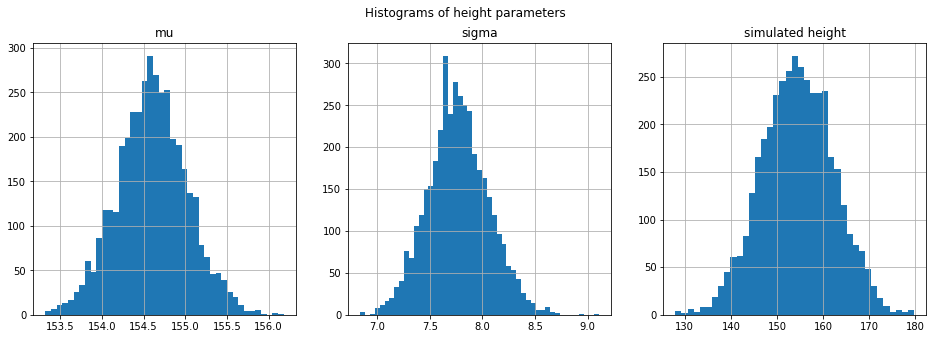

In [11]:
plt.figure(figsize=(16,5))
plt.suptitle('Histograms of height parameters')
plt.subplot(131)
plt.title('mu')
df2['mu'].hist(bins='auto')
plt.subplot(132)
plt.title('sigma')
df2['sigma'].hist(bins='auto')
plt.subplot(133)
plt.title('simulated height')
df2['height'].hist(bins='auto')
plt.show()

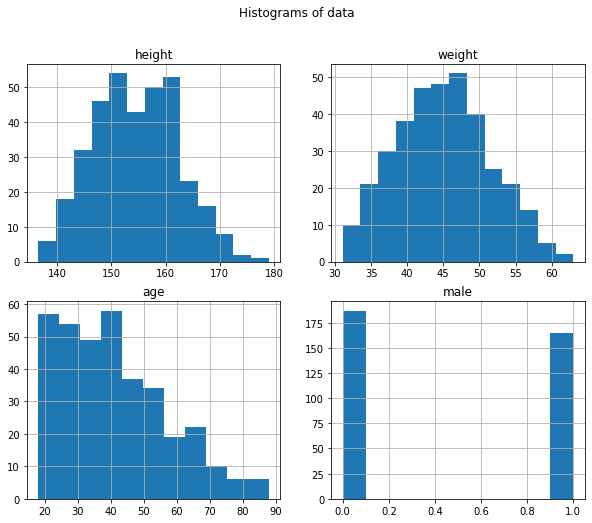

In [12]:
plt.figure(figsize=(10,8))
plt.suptitle('Histograms of data')
plt.subplot(221)
plt.title('height')
d['height'].hist(bins='auto')
plt.subplot(222)
plt.title('weight')
d['weight'].hist(bins='auto')
plt.subplot(223)
plt.title('age')
d['age'].hist(bins='auto')
plt.subplot(224)
plt.title('male')
d['male'].hist(bins='auto')
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [13]:
d['c_weight'] = d['weight'] - d['weight'].mean()
d.head()

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,2.835121
1,139.700,36.485807,63.0,0,-8.504679
2,136.525,31.864838,65.0,0,-13.125648
3,156.845,53.041914,41.0,1,8.051429
4,145.415,41.276872,51.0,0,-3.713614


In [14]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
print(data_sim)

{'N': 50, 'weight': array([-13.91943352, -13.26797358, -12.61651364, -11.9650537 ,
       -11.31359376, -10.66213383, -10.01067389,  -9.35921395,
        -8.70775401,  -8.05629407,  -7.40483413,  -6.75337419,
        -6.10191425,  -5.45045432,  -4.79899438,  -4.14753444,
        -3.4960745 ,  -2.84461456,  -2.19315462,  -1.54169468,
        -0.89023474,  -0.23877481,   0.41268513,   1.06414507,
         1.71560501,   2.36706495,   3.01852489,   3.66998483,
         4.32144477,   4.9729047 ,   5.62436464,   6.27582458,
         6.92728452,   7.57874446,   8.2302044 ,   8.88166434,
         9.53312428,  10.18458421,  10.83604415,  11.48750409,
        12.13896403,  12.79042397,  13.44188391,  14.09334385,
        14.74480379,  15.39626373,  16.04772366,  16.6991836 ,
        17.35064354,  18.00210348])}


## Task 4. Prior predictive checks
 

In [15]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [16]:
df4 = sim.draws_pd()
df4.head()

,lp__,accept_stat__,alpha,sigma,beta,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,218.747,8.126140,-1.746940,247.3870,221.090,253.396,236.706,244.553,...,206.990,211.703,207.775,196.239,181.754,187.475,188.501,195.781,190.755,192.529
1,0.0,0.0,148.419,0.114332,-0.003709,148.6100,148.555,148.551,148.598,148.600,...,148.680,148.369,148.267,148.349,148.256,148.421,148.241,148.346,148.504,148.344
2,0.0,0.0,162.314,30.370300,-1.221870,222.3410,172.810,172.862,195.312,188.102,...,200.593,106.432,191.850,155.304,203.770,143.803,172.925,155.547,139.903,146.802
3,0.0,0.0,152.321,3.525220,-0.507911,164.0760,156.735,157.962,155.038,157.290,...,148.125,146.371,146.875,150.222,143.282,142.812,147.317,142.152,144.939,141.922
4,0.0,0.0,152.118,31.207800,-0.702745,80.4388,142.985,136.520,136.378,200.466,...,192.650,184.039,119.865,147.785,137.465,127.230,124.264,164.036,157.881,114.071


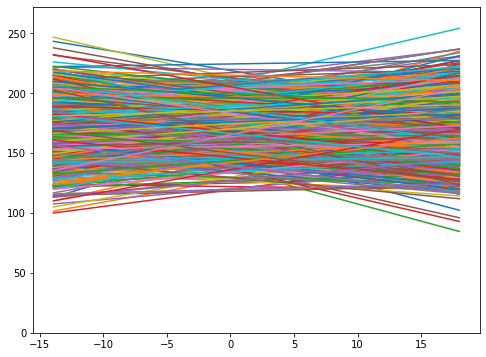

In [17]:
x = np.linspace(d['c_weight'].min(), d['c_weight'].max(), df4.shape[0])
plt.figure(figsize=(8,6))
for i in range(len(x)):
    plt.plot(x, df4['beta'][i]*x + df4['alpha'][i])
plt.ylim(0, 272)
plt.show()

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [18]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [19]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [20]:
df5 = sim.draws_pd()
df5.head()

,lp__,accept_stat__,alpha,sigma,beta,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,218.747,8.126140,0.174307,220.6440,195.599,229.156,213.718,222.817,...,230.312,236.277,233.600,223.316,210.083,217.055,219.333,227.864,224.090,227.115
1,0.0,0.0,148.419,0.114332,0.996298,134.6900,135.287,135.934,136.633,137.286,...,160.819,161.160,161.709,162.443,163.001,163.818,164.289,165.045,165.855,166.346
2,0.0,0.0,162.314,30.370300,0.294677,201.2320,152.689,153.728,177.167,170.945,...,219.002,125.829,212.236,176.677,226.131,167.153,197.263,180.872,166.217,174.103
3,0.0,0.0,152.321,3.525220,0.601751,148.6310,142.012,143.962,141.761,144.736,...,161.595,160.564,161.791,165.861,159.644,159.897,165.125,160.682,164.192,161.898
4,0.0,0.0,152.118,31.207800,0.495224,63.7638,127.091,121.406,122.044,186.913,...,207.192,199.362,135.968,164.669,155.129,145.674,143.488,184.041,178.667,135.637


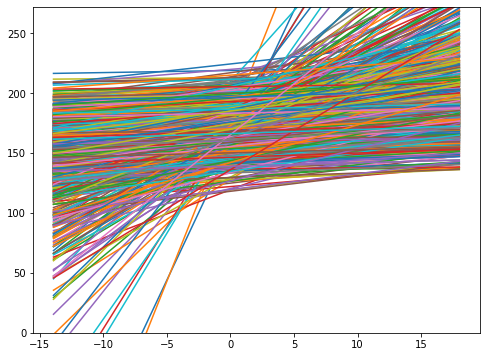

In [21]:
x = np.linspace(d['c_weight'].min(), d['c_weight'].max(), df5.shape[0])
plt.figure(figsize=(8,6))
for i in range(len(x)):
    plt.plot(x, df5['beta'][i]*x + df5['alpha'][i])
plt.ylim(0, 272)
plt.show()

       height     weight    age  male   c_weight
0.00  136.525  31.071052  18.00   0.0 -13.919434
0.05  142.875  34.831613  20.00   0.0 -10.158872
0.25  148.590  40.256290  28.00   0.0  -4.734196
0.50  154.305  44.792210  39.00   0.0  -0.198276
0.75  160.655  49.292693  51.00   1.0   4.302208
0.95  167.005  55.971835  71.45   1.0  10.981350
1.00  179.070  62.992589  88.00   1.0  18.002103


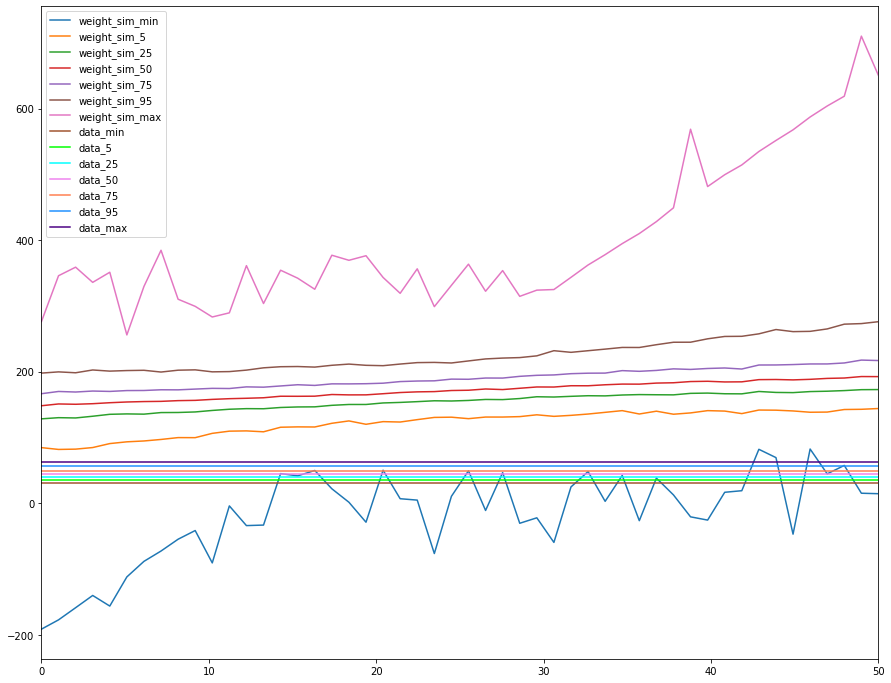

In [53]:
x = np.linspace(0, 50, 50)
weight_sim = df5.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])
weight_sim_min = weight_sim.loc[[0.0]].iloc[:,5:]
weight_sim_5 = weight_sim.loc[[0.05]].iloc[:,5:]
weight_sim_25 = weight_sim.loc[[0.25]].iloc[:,5:]
weight_sim_50 = weight_sim.loc[[0.5]].iloc[:,5:]
weight_sim_75 = weight_sim.loc[[0.75]].iloc[:,5:]
weight_sim_95 = weight_sim.loc[[0.95]].iloc[:,5:]
weight_sim_max = weight_sim.loc[[1.0]].iloc[:,5:]

data = d.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])
data_min = data.loc[[0.0]].iloc[:,1]
data_5 = data.loc[[0.05]].iloc[:,1]
data_25 = data.loc[[0.25]].iloc[:,1]
data_50 = data.loc[[0.5]].iloc[:,1]
data_75 = data.loc[[0.75]].iloc[:,1]
data_95 = data.loc[[0.95]].iloc[:,1]
data_max = data.loc[[1.0]].iloc[:,1]


plt.figure(figsize=(15,12))
plt.plot(x, weight_sim_min.values.T, label='weight_sim_min')
plt.plot(x, weight_sim_5.values.T, label='weight_sim_5')
plt.plot(x, weight_sim_25.values.T, label='weight_sim_25')
plt.plot(x, weight_sim_50.values.T, label='weight_sim_50')
plt.plot(x, weight_sim_75.values.T, label='weight_sim_75')
plt.plot(x, weight_sim_95.values.T, label='weight_sim_95')
plt.plot(x, weight_sim_max.values.T, label='weight_sim_max')

plt.axhline(y=data_min.values, label='data_min', color='sienna')
plt.axhline(y=data_5.values, label='data_5', color='lime')
plt.axhline(y=data_25.values, label='data_25', color='aqua')
plt.axhline(y=data_50.values, label='data_50', color='violet')
plt.axhline(y=data_75.values, label='data_75', color='coral')
plt.axhline(y=data_95.values, label='data_95', color='dodgerblue')
plt.axhline(y=data_max.values, label='data_max', color='indigo')

plt.legend()
plt.xlim(0, 50)
plt.show()

## Task 6. Fitting and evaluating model


In [54]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [56]:
N = 50
data_fit={'N':N, 'heights': d['height'][:N], 'weight':d['c_weight'][:N]}
print(data_fit)

{'N': 50, 'heights': 0     151.7650
1     139.7000
2     136.5250
3     156.8450
4     145.4150
5     163.8300
6     149.2250
7     168.9100
8     147.9550
9     165.1000
10    154.3050
11    151.1300
12    144.7800
13    149.9000
14    150.4950
15    163.1950
16    157.4800
17    143.9418
21    161.2900
22    156.2100
25    146.4000
26    148.5900
27    147.3200
31    147.9550
32    161.9250
33    146.0500
34    146.0500
35    152.7048
36    142.8750
37    142.8750
38    147.9550
39    160.6550
40    151.7650
41    162.8648
42    171.4500
43    147.3200
44    147.9550
49    154.3050
50    143.5100
51    146.7000
52    157.4800
56    165.7350
57    152.4000
58    141.6050
59    158.8000
60    155.5750
61    164.4650
62    151.7650
63    161.2900
64    154.3050
Name: height, dtype: float64, 'weight': 0      2.835121
1     -8.504679
2    -13.125648
3      8.051429
4     -3.713614
5     18.002103
6     -6.747010
7     10.489486
8    -10.120601
9      9.497253
10     4.904634
11    -3.7703

In [57]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status






chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)





chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [58]:
df6 = fit.draws_pd()
df6.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta,alpha,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,-104.104,0.997325,0.786557,3.0,7.0,0.0,105.669,4.37736,0.874327,153.067,...,154.096,162.079,154.215,148.742,162.062,160.279,151.624,153.165,153.475,154.649
1,-104.201,0.997097,0.786557,3.0,7.0,0.0,104.386,5.44955,0.874836,152.732,...,154.123,160.335,148.957,145.116,157.602,159.618,150.001,154.162,161.517,157.664
2,-104.683,0.838554,0.786557,3.0,7.0,0.0,107.464,4.63632,0.763824,153.331,...,156.499,167.079,159.487,142.871,155.798,156.494,161.087,151.778,154.457,157.578
3,-103.759,0.956606,0.786557,2.0,3.0,0.0,105.315,4.88487,0.827769,152.650,...,141.343,167.171,141.543,147.530,154.151,154.288,156.769,155.838,149.035,145.845
4,-104.531,0.931712,0.786557,2.0,3.0,0.0,104.692,4.72145,0.767369,152.472,...,164.446,157.713,148.771,146.403,154.441,162.034,148.423,151.090,155.439,156.751


In [59]:
print(df6.columns.tolist())

['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'sigma', 'beta', 'alpha', 'mu[1]', 'mu[2]', 'mu[3]', 'mu[4]', 'mu[5]', 'mu[6]', 'mu[7]', 'mu[8]', 'mu[9]', 'mu[10]', 'mu[11]', 'mu[12]', 'mu[13]', 'mu[14]', 'mu[15]', 'mu[16]', 'mu[17]', 'mu[18]', 'mu[19]', 'mu[20]', 'mu[21]', 'mu[22]', 'mu[23]', 'mu[24]', 'mu[25]', 'mu[26]', 'mu[27]', 'mu[28]', 'mu[29]', 'mu[30]', 'mu[31]', 'mu[32]', 'mu[33]', 'mu[34]', 'mu[35]', 'mu[36]', 'mu[37]', 'mu[38]', 'mu[39]', 'mu[40]', 'mu[41]', 'mu[42]', 'mu[43]', 'mu[44]', 'mu[45]', 'mu[46]', 'mu[47]', 'mu[48]', 'mu[49]', 'mu[50]', 'height[1]', 'height[2]', 'height[3]', 'height[4]', 'height[5]', 'height[6]', 'height[7]', 'height[8]', 'height[9]', 'height[10]', 'height[11]', 'height[12]', 'height[13]', 'height[14]', 'height[15]', 'height[16]', 'height[17]', 'height[18]', 'height[19]', 'height[20]', 'height[21]', 'height[22]', 'height[23]', 'height[24]', 'height[25]', 'height[26]', 'height[27]', 'height[28]', 'h

In [60]:
df6.shape

(4000, 110)

In [61]:
df6[df6.columns[-50:]].head(1)

,height[1],height[2],height[3],height[4],height[5],height[6],height[7],height[8],height[9],height[10],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,161.932,148.008,148.948,163.06,156.481,171.512,146.571,164.082,145.67,156.291,...,154.096,162.079,154.215,148.742,162.062,160.279,151.624,153.165,153.475,154.649


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:01 Status

chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)







chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status

chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)










chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)



chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


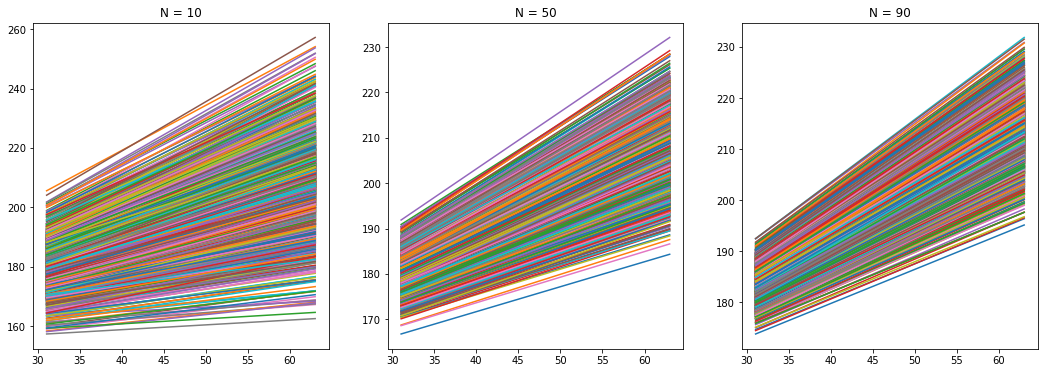

In [68]:
x = np.linspace(d['weight'].min(), d['weight'].max(), df6.shape[0])
N_test = [10, 50, 90]

fig, ax = plt.subplots(1,3, figsize=(18,6))
for i in range(len(N_test)):
    data_fit={'N':N_test[i], 'heights': d['height'][:N_test[i]], 'weight':d['c_weight'][:N_test[i]]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()

    ax[i].set_title('N = {0}'.format(N_test[i]))
    for j in range(len(x)):
        ax[i].plot(x, df['beta'][j]*x + df['alpha'][j])


plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:01 Status

chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)








chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)





chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |█████▍    | 00:01 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)



chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████


INFO:cmdstanpy:CmdStan done processing.


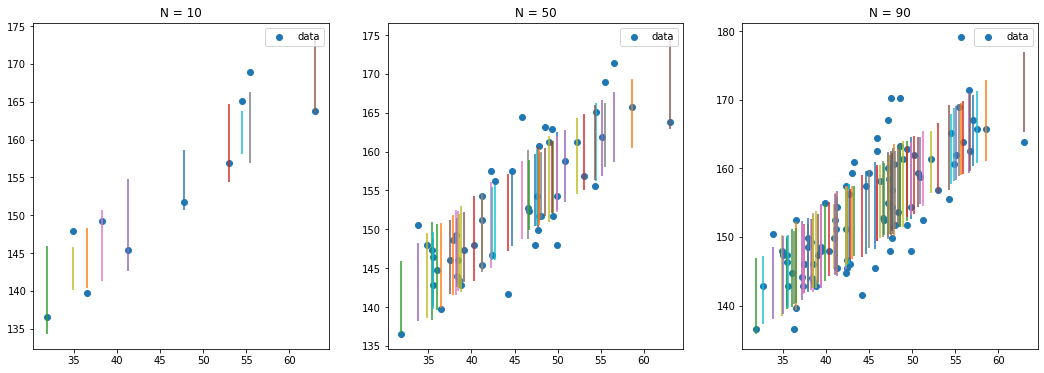

In [76]:
x = np.linspace(d['weight'].min(), d['weight'].max(), df6.shape[0])
N_test = [10, 50, 90]

fig, ax = plt.subplots(1,3, figsize=(18,6))
for i in range(len(N_test)):
    data_fit={'N':N_test[i], 'heights': d['height'][:N_test[i]], 'weight':d['c_weight'][:N_test[i]]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()

    ax[i].set_title('N = {0}'.format(N_test[i]))
    for j in range(N_test[i]-1):
        x = d['weight'][j:j+1]
        y = df[df.columns[-N_test[i]+j:-N_test[i]+j+1]].mean()
        # print(i, y)
        ax[i].errorbar(x, y, yerr=df['sigma'][j])

    # for last y value
    x = d['weight'][N_test[i]-1:N_test[i]]
    y = df[df.columns[-1:]].mean()
    # print(N-1, y)
    ax[i].errorbar(x, y, yerr=df['sigma'][N_test[i]-1])

    ax[i].scatter(d['weight'][:N_test[i]], d['height'][:N_test[i]], label='data')
    ax[i].legend()

plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [77]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')
N = 50
data_fit={'N':N, 'heights': d['height'][:N], 'weight':d['c_weight'][:N]}
fit_v2=model_2_fit.sample(data=data_fit,seed=28052020)
df = fit_v2.draws_pd()
df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)






chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,beta,alpha,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,-104.104,0.997325,0.786557,3.0,7.0,0.0,105.669,4.37736,0.874327,153.067,...,154.096,162.079,154.215,148.742,162.062,160.279,151.624,153.165,153.475,154.649
1,-104.201,0.997097,0.786557,3.0,7.0,0.0,104.386,5.44955,0.874836,152.732,...,154.123,160.335,148.957,145.116,157.602,159.618,150.001,154.162,161.517,157.664
2,-104.683,0.838554,0.786557,3.0,7.0,0.0,107.464,4.63632,0.763824,153.331,...,156.499,167.079,159.487,142.871,155.798,156.494,161.087,151.778,154.457,157.578
3,-103.759,0.956606,0.786557,2.0,3.0,0.0,105.315,4.88487,0.827769,152.650,...,141.343,167.171,141.543,147.530,154.151,154.288,156.769,155.838,149.035,145.845
4,-104.531,0.931712,0.786557,2.0,3.0,0.0,104.692,4.72145,0.767369,152.472,...,164.446,157.713,148.771,146.403,154.441,162.034,148.423,151.090,155.439,156.751


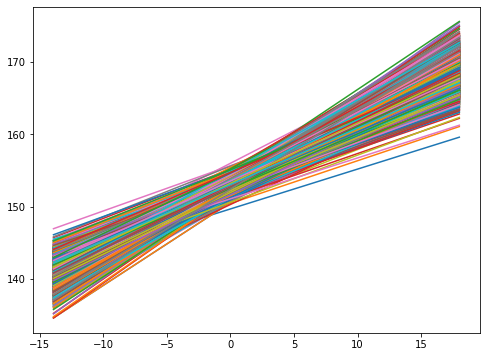

In [78]:
x = np.linspace(d['c_weight'].min(), d['c_weight'].max(), df.shape[0])
plt.figure(figsize=(8,6))
for i in range(len(x)):
    plt.plot(x, df['beta'][i]*x + df['alpha'][i])
plt.show()

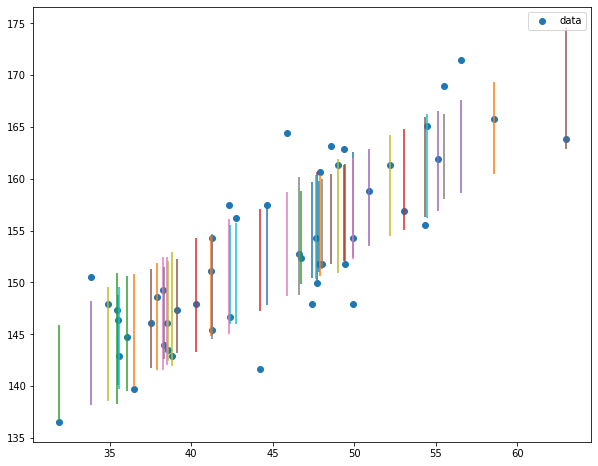

In [81]:
x = np.linspace(d['weight'].min(), d['weight'].max(), df6.shape[0])
N = 50
plt.figure(figsize=(10,8))
for j in range(N-1):
    x = d['weight'][j:j+1]
    y = df[df.columns[-N+j:-N+j+1]].mean()
    # print(i, y)
    plt.errorbar(x, y, yerr=df['sigma'][j])

# for last y value
x = d['weight'][N-1:N]
y = df[df.columns[-1:]].mean()
# print(N-1, y)
plt.errorbar(x, y, yerr=df['sigma'][N-1])
plt.scatter(d['weight'][:N], d['height'][:N], label='data')

plt.legend()
plt.show()

Second power of weight